## N차 과제 - Time Series Analysis_주가예측

- 주제: 시계열 모델을 주가 데이터에 대한 시계열 예측 및 분석
- 데이터: 주식 데이터(크롤링 or 라이브러리로 데이터 불러오기)
- 사용 라이브러리: yfinance, datareader, statsmodels, matplotlib etc.

In [ ]:
!pip install yfinance

In [ ]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose


### 1. EDA 및 전처리

1.1 분석을 위해 사용할 특정 주식(1개)의 데이터를 불러오거나 크롤링하여 가져오세요(**최소 3년 이상의 데이터 추출 권고**).

In [ ]:
start_date = '2019-01-02'
end_date = '2023-12-30'

# yfinance
ticker = yf.Ticker('005930.KS')
df = ticker.history(
               interval='1d',
               start=start_date,
               end=end_date,
               actions=True,
               auto_adjust=False)
df = df.reset_index()
df

,Date,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
0,2019-01-02 00:00:00+09:00,39400.0,39400.0,38550.0,38750.0,33474.058594,7847664,0.0,0.0
1,2019-01-03 00:00:00+09:00,38300.0,38550.0,37450.0,37600.0,32480.628906,12471493,0.0,0.0
2,2019-01-04 00:00:00+09:00,37450.0,37600.0,36850.0,37450.0,32351.058594,14108958,0.0,0.0
3,2019-01-07 00:00:00+09:00,38000.0,38900.0,37800.0,38750.0,33474.058594,12748997,0.0,0.0
4,2019-01-08 00:00:00+09:00,38000.0,39200.0,37950.0,38100.0,32912.554688,12756554,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1226,2023-12-21 00:00:00+09:00,74600.0,75000.0,74300.0,75000.0,73978.890625,13478766,0.0,0.0
1227,2023-12-22 00:00:00+09:00,75800.0,76300.0,75400.0,75900.0,74866.632812,14515608,0.0,0.0
1228,2023-12-26 00:00:00+09:00,76100.0,76700.0,75700.0,76600.0,75557.109375,13164909,0.0,0.0
1229,2023-12-27 00:00:00+09:00,76700.0,78000.0,76500.0,78000.0,77302.359375,20651042,361.0,0.0


1.2 결측치가 있는지 확인하고 있다면 제거해주세요.

In [ ]:
df.isna().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0
Dividends,0
Stock Splits,0


1.3 일자를 인덱스로 설정하고 시간 순서대로 정렬하세요.

In [ ]:
df = df.set_index('Date')
df = df.sort_values(by='Date', ascending=True)
df

,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
Date,,,,,,,,
2019-01-02 00:00:00+09:00,39400.0,39400.0,38550.0,38750.0,33474.058594,7847664,0.0,0.0
2019-01-03 00:00:00+09:00,38300.0,38550.0,37450.0,37600.0,32480.628906,12471493,0.0,0.0
2019-01-04 00:00:00+09:00,37450.0,37600.0,36850.0,37450.0,32351.058594,14108958,0.0,0.0
2019-01-07 00:00:00+09:00,38000.0,38900.0,37800.0,38750.0,33474.058594,12748997,0.0,0.0
2019-01-08 00:00:00+09:00,38000.0,39200.0,37950.0,38100.0,32912.554688,12756554,0.0,0.0
...,...,...,...,...,...,...,...,...
2023-12-21 00:00:00+09:00,74600.0,75000.0,74300.0,75000.0,73978.890625,13478766,0.0,0.0
2023-12-22 00:00:00+09:00,75800.0,76300.0,75400.0,75900.0,74866.632812,14515608,0.0,0.0
2023-12-26 00:00:00+09:00,76100.0,76700.0,75700.0,76600.0,75557.109375,13164909,0.0,0.0


1.4 수정종가(adj close)와 거래량(volume)을 시각화하세요.

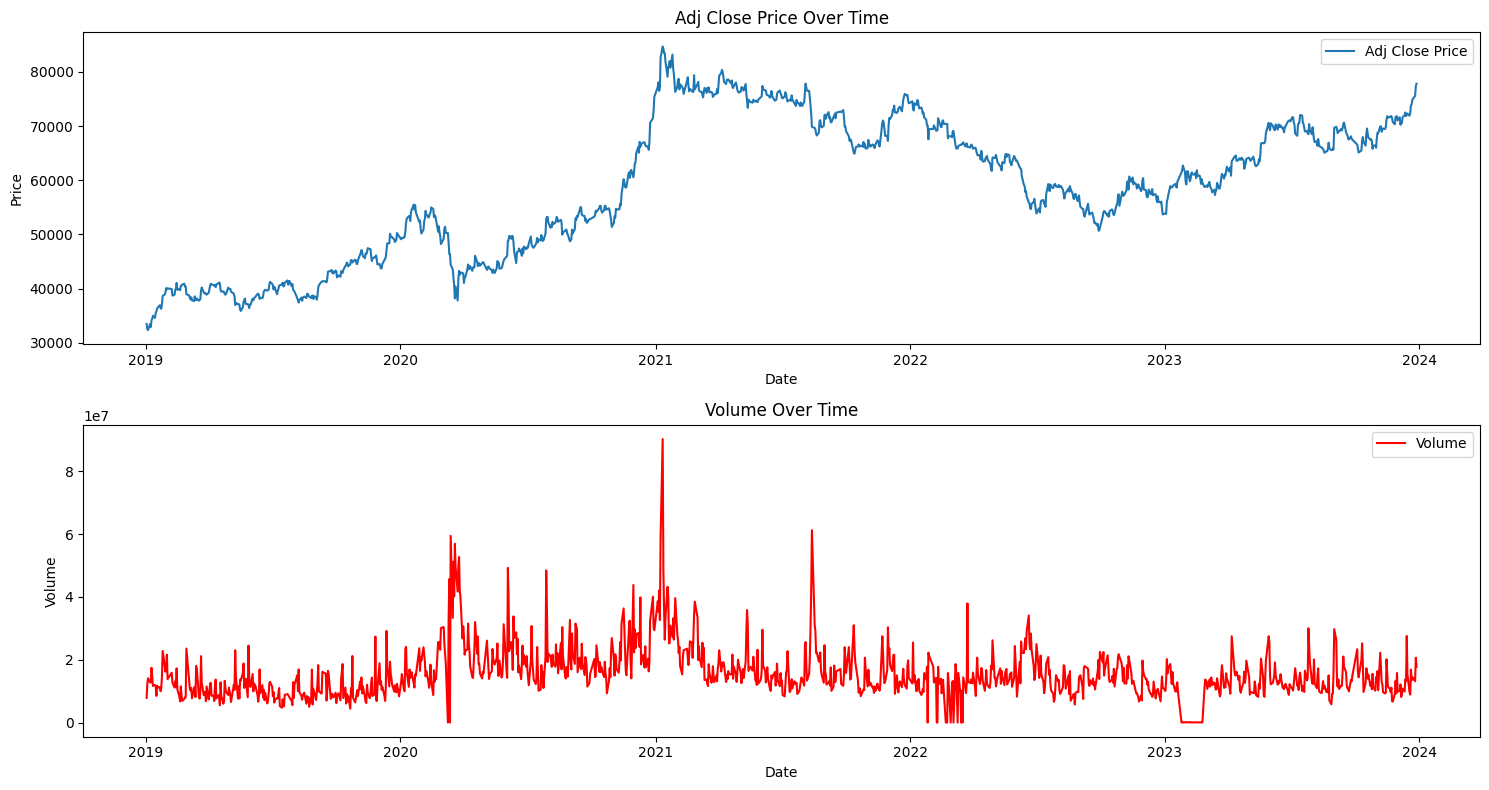

In [ ]:
import seaborn as sns

# 1행 2열의 그래프를 위 아래로 나눠서 그리기
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))  # 2x1 그리드, (8, 6)은 figure의 크기

sns.lineplot(x='Date', y='Adj Close', data=df, label='Adj Close Price', ax=ax1)
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.set_title('Adj Close Price Over Time')
ax1.legend()

sns.lineplot(x='Date', y='Volume', data=df, label='Volume', ax=ax2, color='r')
ax2.set_xlabel('Date')
ax2.set_ylabel('Volume')
ax2.set_title('Volume Over Time')
ax2.legend()

# 그래프 간의 간격 조정
plt.tight_layout()
plt.show()

1.5 위 시각화 과정을 통해 알 수 있는 내용에 대해 작성하세요.

2020년 주식 가격이 하락세일 때 거래량이 증가하였고 2021년 주식가격이 상승세일 때 거래량이 크게 증가하였음을 알 수 있다.

### 2. 추세 및 정상성 검정

2.1 시계열 데이터의 정상성을 검증하도록 하겠습니다. 시계열 데이터 말하는 정상성(stationarity)이 무엇인지 왜 해야 하며 비정상성의 해결 방법에는 무엇이 있는지 작성하세요.

**정상성**이란 시계열의 평균과 분산이 일정하고, 특정한 트렌드 (추세)가 존재하지 않는 성질을 의미합니다. 정상성이 중요한 이유는 시계열의 평균과 분산이 일정해야 시계열 값을 예측할 수 있기 때문입니다. 시계열 자료가 정상성을 띠지 않으면, AR, MA, ARIMA 등 전통적인 시계열 분석 방법들을 사용하기 어렵기 때문에 시계열 자료들에 차분과 로그 변환을 취해 정상성을 띠도록 만들어야 합니다.
* 차분은 t시점과 (t-1)시점의 값의 차이를 구하는 것을 의미합니다.
* 로그 변환을 통해 정상성을 띠지 않는 시계열 자료의 분산을 줄일 수 있습니다.

2.2 먼저 ADF Test를 수행하겠습니다. statsmodels의 adfuller 라이브러리를 import 한 후 수정 종가에 대한 검정을 수행하고 결과를 출력하세요(p-value 포함).

ADF Test란? - https://hongl.tistory.com/98

In [ ]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(df['Adj Close'], autolag='AIC')
print("ADF Statistic: ", dftest[0])
print("p-value: ", dftest[1])

ADF Statistic:  -1.4969633316910964
p-value:  0.5350129968713906


2.3 ADF Test 결과를 해석하세요.

p-value가 0.05보다 크므로 귀무가설을 기각할 수 없다. 즉, 정상성을 띠지 않는다.

2.4 ACF 그래프와 PACF 그래프를 그려보도록 하겠습니다. 먼저 ACF와 PACF 각각이 어떻게 다른지 설명하세요.

시차에 따른 일련의 자기상관을 자기상관함수 ACF(Auto Correlation Function)라고 한다. ACF는 시차에 따른 관측값 간의 연관 정도를 보여주며, 시차가 커질수록 ACF는 점차 0에 가까워진다. 정상 시계열의 경우 ACF는 상대적으로 빨리 0으로 접근한다.

시차에 따른 일련의 편자기 상관을 편자기 상관함수 PACF(Partial Auto Correlation Function)라고 한다. PACF는 시차가 다른 두 시계열 데이터 간의 순수한 상호 연관성을 나타낸다. 즉, t시점과 t-1시점의 연관성 t와 t-2의 연관성

2.5 statsmodels의 plot_acf, plot_pacf 라이브러리를 import하고 Adj close값에 대한 ACF, PACF 그래프를 출력하세요.

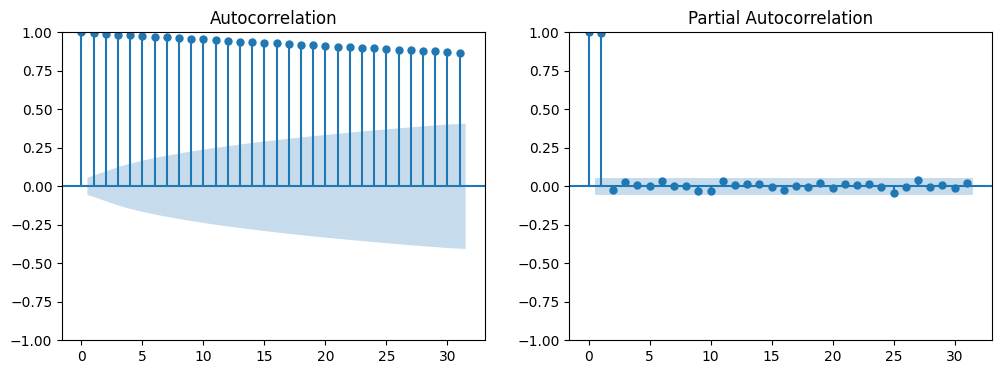

In [ ]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 시각화
# subplot생성
fig, ax = plt.subplots(1,2 , figsize = (12,4))

# acf plot
plot_acf(df['Adj Close'], ax = ax[0])

# pacf plot
plot_pacf(df['Adj Close'], ax= ax[1])
plt.show()

2.6 결과를 해석하세요.

ACF 수치가 큰 값에서 천천히 떨어지므로 정상성을 띠지 않고 PACF값이 3번째부터 0에 가까워지므로 AFRIMA 모델의 AR(2)가 적합할 것으로 해석된다.

2.7 마지막으로 계절성이 있는지 여부를 확인하겠습니다. statsmodels의 seasonal_decompose 라이브러리를 import하고 plot을 출력하세요.

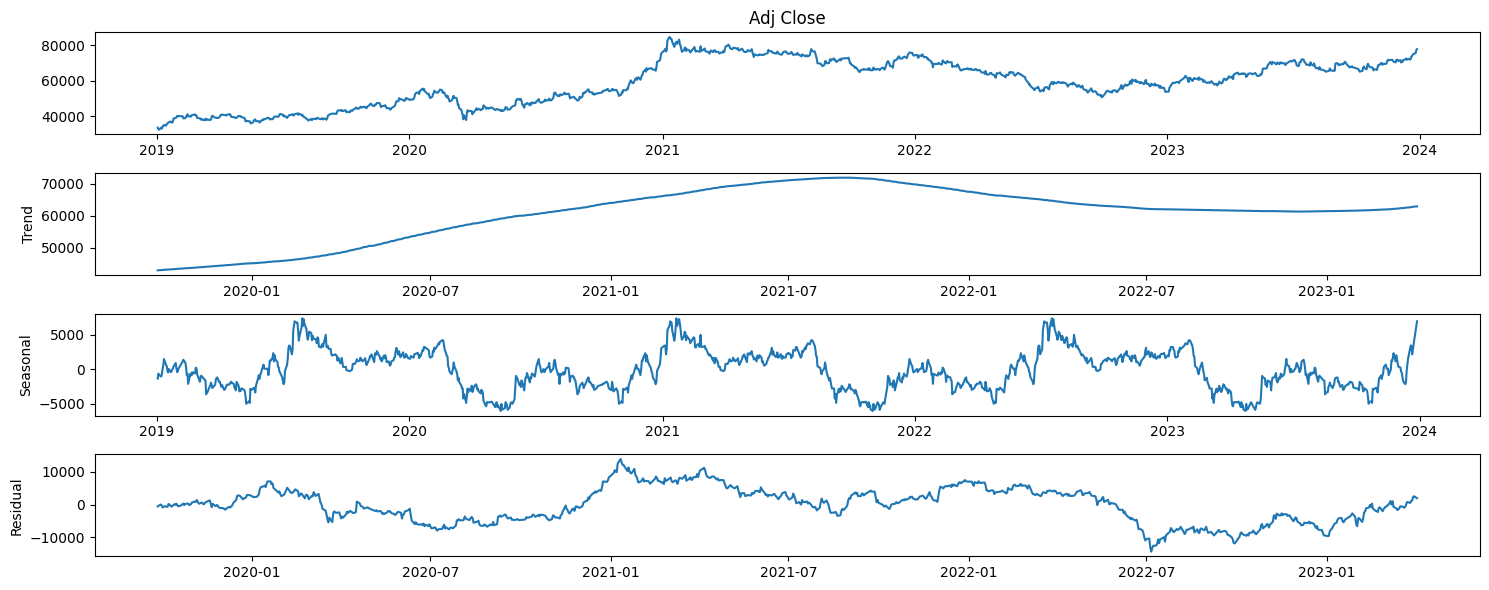

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df['Adj Close'], model='additive',period=365)

plt.figure(figsize=(15, 6))
plt.subplot(4, 1, 1)
plt.plot(df['Adj Close'])
plt.title('Adj Close')

plt.subplot(4, 1, 2)
plt.plot(result.trend)
plt.ylabel('Trend')

plt.subplot(4, 1, 3)
plt.plot(result.seasonal)
plt.ylabel('Seasonal')

plt.subplot(4, 1, 4)
plt.plot(result.resid)
plt.ylabel('Residual')

plt.tight_layout()
plt.show()

2.8 위 결과를 해석하세요.

추세는 상승하다가 하락하고, 약 1년 반 단위의 계절성을 가지고 있다.

2.9 위에서 진행한 검정 과정 및 시각화 결과를 종합해봤을 때 현 데이터는 비정상성임을 알 수 있습니다. 따라서 차분을 통해 이를 해결하도록 하겠습니다. 먼저 차분이 어떤 것인지에 대해 설명하세요.

차분(differencing)이란 주어진 시계열의 변화분을 구하는 과정을 말한다. t번째 시계열이 X_t라고 할 때 차분 시계열은 X_t - X_t-1 을 만족한다.

2.10 1차 차분을 진행하도록 하겠습니다. diff() 함수를 활용해 1차 차분을 진행한 후 ADF Test를 수행하여 정상성 여부를 확인하세요.

In [ ]:
import numpy as np
df['Adj Close_diff'] = df['Adj Close'].diff(periods=1)
df = df.dropna()
dftest = adfuller(df['Adj Close_diff'], autolag='AIC')
print("ADF Statistic: ", dftest[0])
print("p-value: ", dftest[1])

ADF Statistic:  -10.353707437598247
p-value:  2.4981725667892974e-18


2.11 추가로 위에서 그려보았던 plot들을 다시 그려보면서 비교를 통해 정상성 여부를 확인해보도록 하겠습니다. ACF PACF plot, 계절성 분해 plot을 그려보세요.

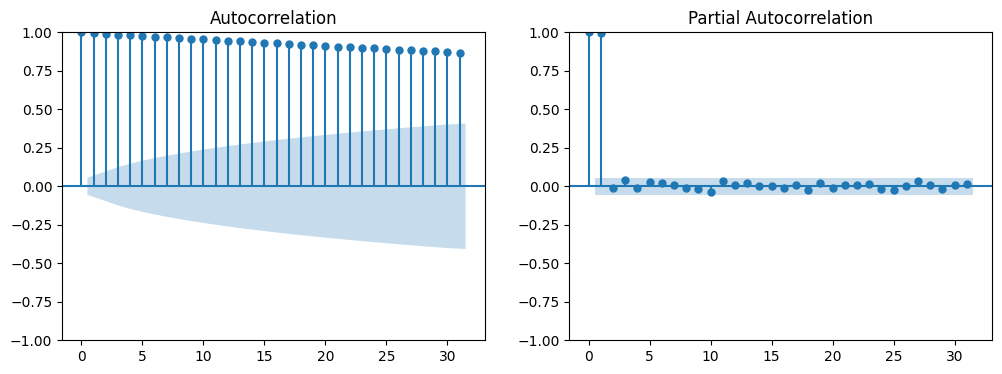

In [ ]:
# 시각화
# subplot생성
fig, ax = plt.subplots(1,2 , figsize = (12,4))

# acf plot
plot_acf(df['Adj Close'], ax = ax[0])

# pacf plot
plot_pacf(df['Adj Close'], ax= ax[1])
plt.show()

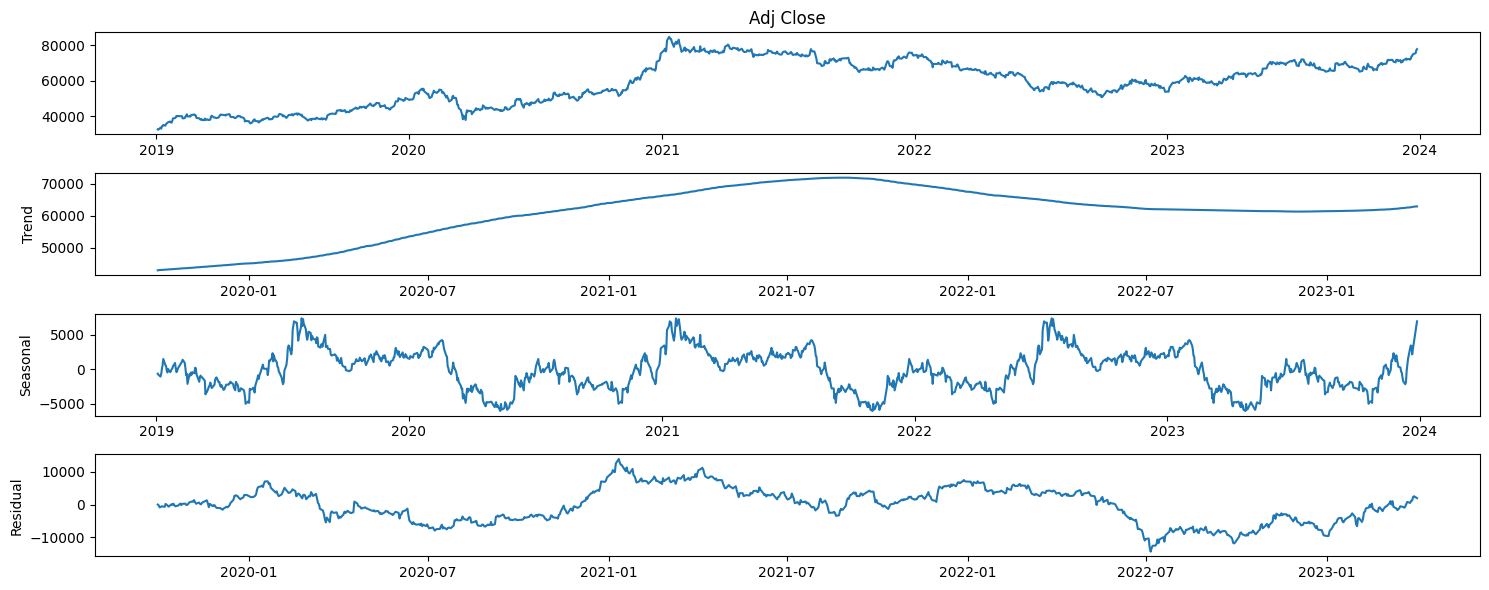

In [ ]:
result = seasonal_decompose(df['Adj Close'], model='additive',period=365)

plt.figure(figsize=(15, 6))
plt.subplot(4, 1, 1)
plt.plot(df['Adj Close'])
plt.title('Adj Close')

plt.subplot(4, 1, 2)
plt.plot(result.trend)
plt.ylabel('Trend')

plt.subplot(4, 1, 3)
plt.plot(result.seasonal)
plt.ylabel('Seasonal')

plt.subplot(4, 1, 4)
plt.plot(result.resid)
plt.ylabel('Residual')

plt.tight_layout()
plt.show()

### 3. 예측

3.1 데이터의 정상성을 확인했으니 본격적으로 예측 및 분석을 진행해보도록 하겠습니다.

아래 코드는 예시이므로 예시에서 사용된 모델이 아닌 다른 모델(ex. ARIMAX, ARCH/GARCH, LSTM, Transformer, DLinear etc.)를 사용하고 애플이 아닌 다른 주식을 사용해 예측 및 분석을 진행해주세요(**위에서 진행한 과정 역시 모두 예시이므로 새로운 주식에 대한 전처리 및 정상성 검정을 새로 진행해야 함**).

In [48]:
start_date = '2019-01-01'
end_date = '2024-01-01'

# yfinance
ticker = yf.Ticker('005930.KS')
df = ticker.history(
               interval='1d',
               start=start_date,
               end=end_date,
               actions=True,
               auto_adjust=False)
df = df.reset_index()
df

,Date,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
0,2019-01-02 00:00:00+09:00,39400.0,39400.0,38550.0,38750.0,33474.054688,7847664,0.0,0.0
1,2019-01-03 00:00:00+09:00,38300.0,38550.0,37450.0,37600.0,32480.630859,12471493,0.0,0.0
2,2019-01-04 00:00:00+09:00,37450.0,37600.0,36850.0,37450.0,32351.058594,14108958,0.0,0.0
3,2019-01-07 00:00:00+09:00,38000.0,38900.0,37800.0,38750.0,33474.054688,12748997,0.0,0.0
4,2019-01-08 00:00:00+09:00,38000.0,39200.0,37950.0,38100.0,32912.550781,12756554,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1226,2023-12-21 00:00:00+09:00,74600.0,75000.0,74300.0,75000.0,73978.890625,13478766,0.0,0.0
1227,2023-12-22 00:00:00+09:00,75800.0,76300.0,75400.0,75900.0,74866.640625,14515608,0.0,0.0
1228,2023-12-26 00:00:00+09:00,76100.0,76700.0,75700.0,76600.0,75557.109375,13164909,0.0,0.0
1229,2023-12-27 00:00:00+09:00,76700.0,78000.0,76500.0,78000.0,77302.359375,20651042,361.0,0.0


# 정규화 처리

In [61]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']
# 스케일 후 columns
df_scaled = scaler.fit_transform(df[scale_cols])
df = pd.DataFrame(df_scaled, columns=scale_cols)
df

,Open,High,Low,Close,Volume,Adj Close
0,0.036897,0.030405,0.032289,0.024276,0.086901,0.021465
1,0.016083,0.016047,0.011396,0.002801,0.138102,0.002477
2,0.000000,0.000000,0.000000,0.000000,0.156235,0.000000
3,0.010407,0.021959,0.018044,0.024276,0.141175,0.021465
4,0.010407,0.027027,0.020893,0.012138,0.141259,0.010732
...,...,...,...,...,...,...
1226,0.702933,0.631757,0.711301,0.701214,0.149256,0.795667
1227,0.725639,0.653716,0.732194,0.718021,0.160738,0.812636
1228,0.731315,0.660473,0.737892,0.731092,0.145781,0.825833
1229,0.742668,0.682432,0.753086,0.757236,0.228678,0.859192


# LSTM을 이용하여 예측

In [62]:
X = df.drop('Adj Close', axis=1)
y = df['Adj Close']

In [63]:
import tensorflow as tf

# 데이터셋 구성
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)  # 데이터를 2차원으로 변형
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [64]:
# Hyperparameter
WINDOW_SIZE=50
BATCH_SIZE=32

In [65]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=False)

# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [66]:
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 50, 1)
데이터셋(Y) 구성(batch_size, feature갯수): (32, 1)


In [67]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [68]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [69]:
import os
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.weights.h5')
checkpoint = ModelCheckpoint(filename,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

In [74]:
history = model.fit(train_data,
                    validation_data=(test_data),
                    epochs=100,
                    callbacks=[checkpoint, earlystopping])

Epoch 1/100
     28/Unknown 1s 21ms/step - loss: 2.5052e-04 - mse: 5.0104e-04
Epoch 1: val_loss did not improve from 0.00020
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 2.5147e-04 - mse: 5.0293e-04 - val_loss: 2.2071e-04 - val_mse: 4.4142e-04
Epoch 2/100
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.3515e-04 - mse: 4.7030e-04
Epoch 2: val_loss did not improve from 0.00020
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 2.3695e-04 - mse: 4.7391e-04 - val_loss: 2.0370e-04 - val_mse: 4.0741e-04
Epoch 3/100
28/30 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.7041e-04 - mse: 5.4082e-04
Epoch 3: val_loss improved from 0.00020 to 0.00019, saving model to tmp/ckeckpointer.weights.h5
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 2.6972e-04 - mse: 5.3944e-04 - val_loss: 1.9415e-04 - val_mse: 3.8830e-04
Epoch 4/100
28/30 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.2158e-04 - mse: 4.4316e-04
Epoch 4: val_loss did not improve from 0.00019
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 2.24

In [75]:
# 저장한 ModelCheckpoint 를 로드합니다.
model.load_weights(filename)

In [76]:
# test_data를 활용하여 예측을 진행합니다.
pred = model.predict(test_data)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


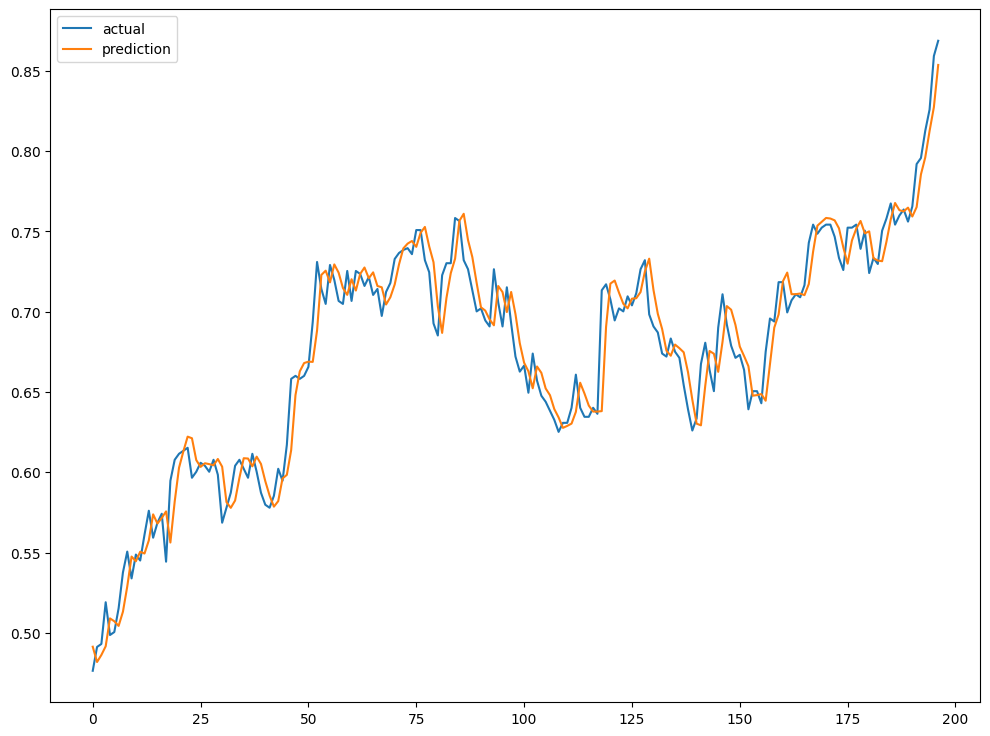

In [77]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[50:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [113]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(np.asarray(y_test)[50:], pred))
mae = mean_absolute_error(np.asarray(y_test)[50:], pred)

print("RMSE:", rmse)
print("MAE:", mae)

RMSE: 0.017227913867160025
MAE: 0.01348826779571267


### Prophet

Prophet 모델이란?
https://wikidocs.net/233162

In [47]:
from prophet import Prophet

In [106]:
###Prophet의 경우 ARIMA와 검정 및 전처리 과정이 약간 달라 새로 진행하였으며 보다 정확한 추세 예측을 위해 200일까지 예측하였습니다.###


ticker = '005930.KS'
data = yf.download(ticker, start='2019-01-01', end='2024-01-01')

df = data.reset_index()[['Date', 'Close']]
df.columns = ['ds', 'y']  #Prophet에서는 날짜 컬럼을 'ds', 값 컬럼을 'y'로 설정해야 함

[*********************100%***********************]  1 of 1 completed


In [107]:
#모델 설정(파라미터는 따로 설정하지 않고 진행했으나 보다 정확한 예측을 위해 수정하는 것도 좋음)
model = Prophet()
model.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp12bnohjo/amdbz3fc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp12bnohjo/_zun06_k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21813', 'data', 'file=/tmp/tmp12bnohjo/amdbz3fc.json', 'init=/tmp/tmp12bnohjo/_zun06_k.json', 'output', 'file=/tmp/tmp12bnohjo/prophet_model2rrg9_6p/prophet_model-20241008135033.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:50:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:50:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [108]:
#200일간의 예측 진행
future = model.make_future_dataframe(periods=200)
forecast = model.predict(future)

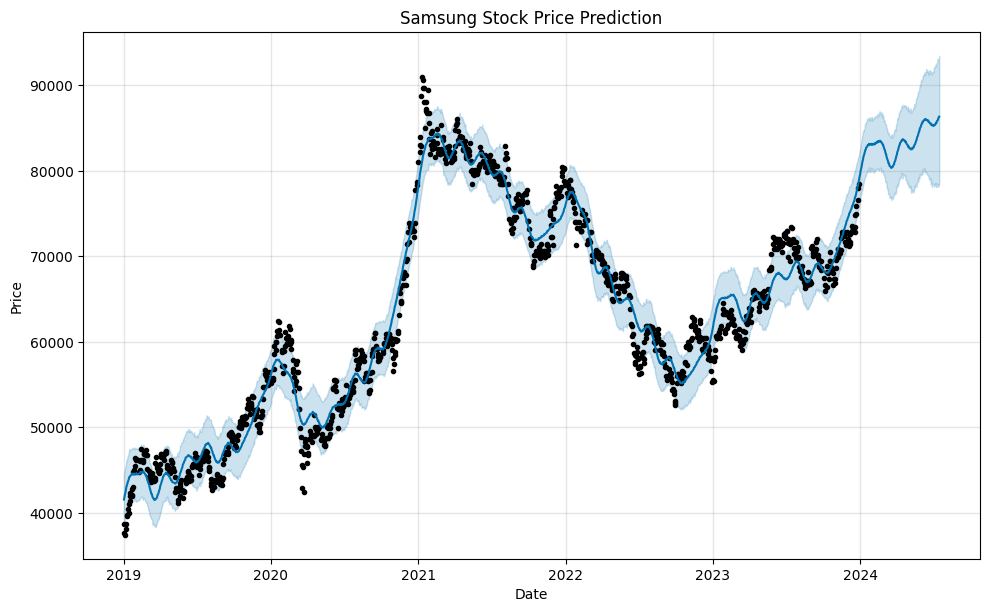

In [109]:
# 예측 결과 시각화
fig1 = model.plot(forecast)
plt.title('Samsung Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

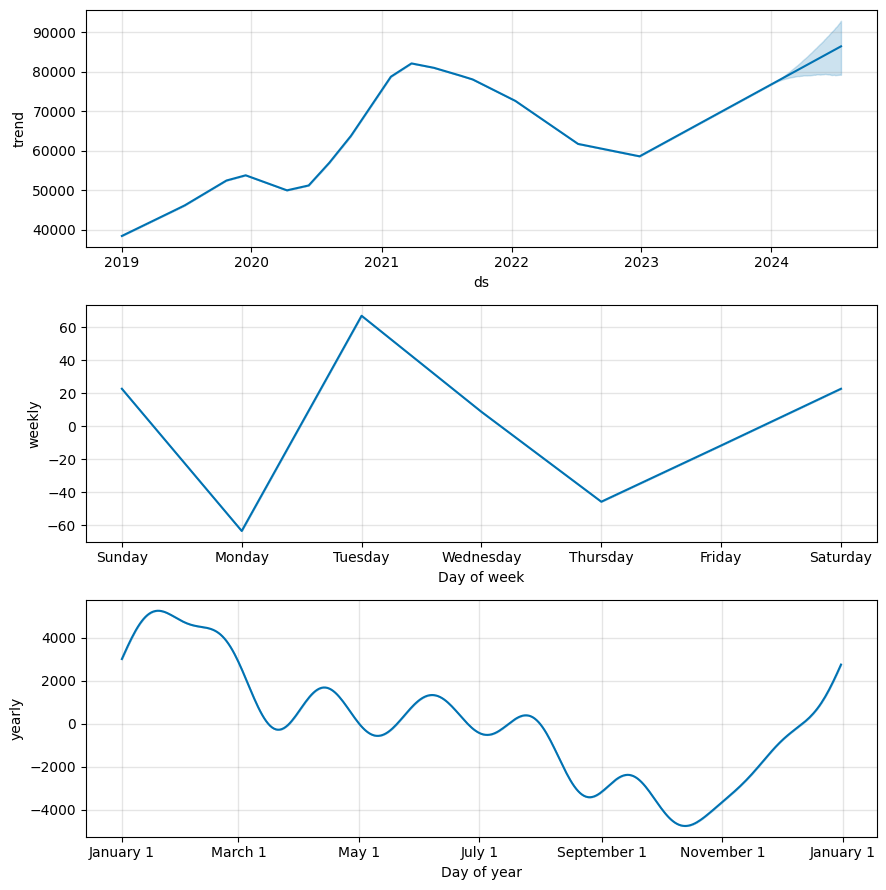

In [110]:
#트렌드 및 주기성 시각화
fig2 = model.plot_components(forecast)
plt.show()

In [111]:
#마지막 200일의 실제 주가 데이터 가져오기
actual_data_last_50 = yf.download(ticker, start='2024-01-01', end='2024-08-01')
actual_last_50 = actual_data_last_50.reset_index()[['Date', 'Close']]
actual_last_50.columns = ['ds', 'y']

[*********************100%***********************]  1 of 1 completed


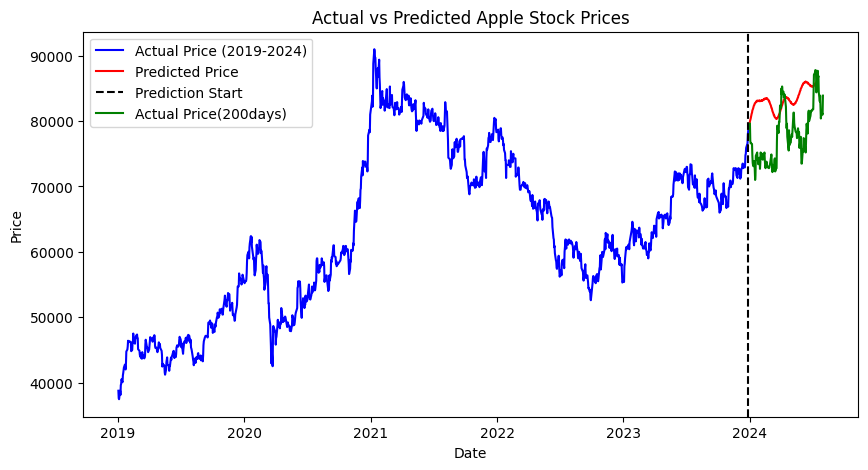

In [112]:
#실제 값과 비교 시각화
plt.figure(figsize=(10, 5))
plt.plot(df['ds'], df['y'], label='Actual Price (2019-2024)', color='blue')

plt.plot(forecast['ds'][len(df):], forecast['yhat'][len(df):], label='Predicted Price', color='red') ##전체 예측값 중 200일 이후 것만 사용
plt.axvline(x=df['ds'].iloc[-1], color='black', linestyle='--', label='Prediction Start')
plt.plot(actual_last_50['ds'], actual_last_50['y'], label='Actual Price(200days)', color='green')
plt.title('Actual vs Predicted Apple Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


예시에서는 전통적 시계열 모형인 ARIMA 보다 최신 기법인 Prophet이 보다 좋은 성능을 보였습니다.

사실 ARIMA로도 좋은 예측을 진행할 수는 있으나 조금 간단하게 진행하였으며(죄송합니다..시간관계상 ㅠ) SARIMA, ARIMAX와 같이 발전된 모형을 사용하는 것도 방법입니다.

예시보다 좋은 예측을 진행하여 주시길 바라며 단순히 시각화하는 것을 넘어서 ***RMSE***나 ***MAE***와 같은 성능지표를 활용해 정량적 평가를 진행해주시면 좋을 것 같습니다.